### Simple Chatbot with Tool

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [ ]:
!pip install arxiv

In [ ]:
#Loading all environment variables
from google.colab import userdata
groq_api_key = userdata.get("GROQ_API_KEY")
langsmith = userdata.get("LANGSMITH_API_KEY")
# tavily_api_key = userdata.get("TAVILY_API_KEY")

In [ ]:
#Importing required libraries
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import List, TypedDict
from typing_extensions import Annotated
from langgraph.graph.message import add_messages
import os

In [ ]:
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LLMTools"

In [ ]:
from typing import TypedDict
#Create a StateGraph
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [ ]:
#Define LLM model
llm = ChatGroq(model = "openai/gpt-oss-20b", api_key = groq_api_key)

In [ ]:
#Create a tool
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper= arxiv_wrapper)

In [ ]:
#Create a custom function
def multiply(a:int, b:int) -> int:
  """Multiply a by b
  Args:
    a(int) : first int
    b(int) : second int

  Retruns:
    int: output int
  """
  return a * b

In [ ]:
#Now LLM with Tool
tools = [arxiv_tool, multiply]
llm_with_tool = llm.bind_tools(tools = tools)

In [ ]:
#Create a node function
def chatbot(state:State):
  return {"messages": [llm_with_tool.invoke(state["messages"])]}

In [ ]:
#Build the Graph
workflow = StateGraph(State)
#Add node
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", ToolNode(tools=tools))
#Add edge
workflow.add_edge(START, "chatbot")

workflow.add_conditional_edges(
    "chatbot",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
workflow.add_edge("tools", END)

#Compile the graph
graph = workflow.compile()

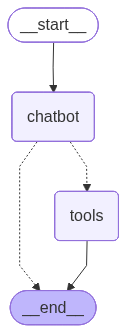

In [ ]:
#Visualize the graph
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
while True:
  user_input= input("User: ")
  if user_input.lower() in ["quit" ,'q']:
    print("Good Bye!")
    break
  for event in graph.stream({"messages": ('user', user_input)}):
    # print(event.values())
    for value in event.values():
      print("Assitant: ", value["messages"][0])

User: Heyy!
Assitant:  content='Hey! How’s it going?' additional_kwargs={'reasoning_content': 'The user says "Heyy!". It\'s a casual greeting. We should respond politely. No function needed.'} response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 225, 'total_tokens': 263, 'completion_time': 0.046488182, 'prompt_time': 0.019937561, 'queue_time': 0.478967399, 'total_time': 0.066425743}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--623cd2f8-782a-45bc-86dd-26ef9a8ffd5b-0' usage_metadata={'input_tokens': 225, 'output_tokens': 38, 'total_tokens': 263}
User: What is 5 multiply by 4?
Assitant:  content='' additional_kwargs={'reasoning_content': 'User asks: "What is 5 multiply by 4?" We should use multiply function.', 'tool_calls': [{'id': 'fc_0300807f-ba19-4ecb-8945-4898cd556713', 'function': {'arguments': '{"a":5,"b":4}', 'name': 'multiply'}, 'type': 'function'

In [ ]:
while True:
  user_input = input("User:  ")
  if user_input.lower() in ["quit", "q"]:
    print("Good Bye!!")
    break
  for event in graph.stream({"messages": [('user', user_input)]}, stream_mode= "values"):
    event["messages"][-1].pretty_print()


User:  Hey!
================================ Human Message =================================

Hey!
================================== Ai Message ==================================

Hey there! How can I help you today?
User:  What is 4 * 5?
================================ Human Message =================================

What is 4 * 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_e4176b57-e5e5-41cc-bf4b-16b2cb2349b2)
 Call ID: fc_e4176b57-e5e5-41cc-bf4b-16b2cb2349b2
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: multiply

20
User:  What is yolov9?
================================ Human Message =================================

What is yolov9?
================================== Ai Message ==================================

## YOLOv9 – A quick guide

| Item | Detail |
|------|--------|
| **What it is** | YOLOv9 is the ninth public release in the “You Only Look

In [ ]:
graph.invoke({"messages": "What is yolov9 and then multiply 8 * 3?"})

{'messages': [HumanMessage(content='What is yolov9 and then multiply 8 * 3?', additional_kwargs={}, response_metadata={}, id='d1131868-393c-490d-b8e5-88ac0468fab5'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to answer the question about yolov9, then multiply 8*3. Use function multiply. Also maybe we can mention yolov9. Provide explanation. Then call the function.', 'tool_calls': [{'id': 'fc_7a3ed90e-d45b-4565-a6a8-b1bbcb1e546e', 'function': {'arguments': '{"a":8,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 236, 'total_tokens': 302, 'completion_time': 0.087533786, 'prompt_time': 0.015849775, 'queue_time': 0.275668037, 'total_time': 0.103383561}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e776b965-a20d-44aa-98d7-c3d14abc0784-0', tool_calls=[{'name': 'multi

In [ ]:
graph.invoke({"messages": "What is bert and then multiply 3 * 4?"})

{'messages': [HumanMessage(content='What is bert and then multiply 3 * 4?', additional_kwargs={}, response_metadata={}, id='a96602ec-4682-497d-aa9c-2a837f62e6f1'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "What is bert and then multiply 3 * 4?" We need to answer about BERT and then multiply 3*4. Probably we need to use the function multiply. Also maybe we need to search arxiv for BERT? The question: "What is bert and then multiply 3 * 4?" Likely they want explanation of BERT (Bidirectional Encoder Representations from Transformers) and then the result of multiplication. We should provide explanation. Use function multiply to compute 3*4. Also maybe we can use arxiv to look up BERT? The question is simple. We can answer: BERT is a transformer-based model. Then 3*4=12. Use function.', 'tool_calls': [{'id': 'fc_9545cb63-7928-4336-8f15-171c8484c86b', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={